<a href="https://colab.research.google.com/github/dkapitan/jads-nhs-proms/blob/master/notebooks/2.0-data-understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Understanding

This is day 1 from the [5-day Python curriculum](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/outline.md)
    

## Learning objectives: descriptive statistics
- Explore Y
- Define Y with results exploration combined with clinical knowledge
- Assess missing values
- Assess data structure
- Explore correlation plot (X, Y)

### Python skills
- Use [pandas](https://pandas.pydata.org/docs/user_guide/index.html) to:
  - [Explore the data](https://realpython.com/pandas-python-explore-dataset/)
  - 
- Be aware of some `pandas` pitfalls:
  - Know how `pandas` uses copies by default and good practice not to replace in-place
  - Use Int64 for N/A


In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import sklearn.linear_model


# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('ggplot')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

In [0]:
# import data
df = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

# alternatively, if you have cloned this repository, read local file
# df = pd.read_parquet('../data/interim/knee-provider.parquet')

## Explore Y
Assume that primary reasons to replace a knee is to **i) reduce pain**, and **ii) improve daily functioning**. The dataset contains the various patient-reported outcome measures that can be used to measure the outcome along these two dimenions:
- Oxford Knee Score (OKS): a 12-item questionnaire that assess daily functioning c.q. disability due to knee osteoarthritis. Items are scored from [0,4], where higher is better (no disability).  
  - OKS question on pain and night pain, both on scale from [0,4]
  - OKS , higher is better. The OKS is a 12-item questionaire that assess daily functioning c.q. disability.
- EQ5D: generic quality of life PROMs along 5 dimensions on a 3-point Likert scale [1,3], lower is better. Dimensions are problems activity, anxiety, discomfort, mobility and self-care.
- EQ-VAS: general reported health on a scale from [0,100], higher is better.

We will explore the PROMs data to see which target variable Y is meaningful to assess the outcome of knee replacement. Note PROMs are measured at T0 (prior to surgery) and T1 (six months after surgery).

In [3]:
# list columns
df.columns

Index(['provider_code', 'procedure', 'revision_flag', 'year', 'age_band',
       'gender', 't0_assisted', 't0_assisted_by', 't0_symptom_period',
       't0_previous_surgery', 't0_living_arrangements', 't0_disability',
       'heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease',
       'diabetes', 'kidney_disease', 'nervous_system', 'liver_disease',
       'cancer', 'depression', 'arthritis', 't0_mobility', 't0_self_care',
       't0_activity', 't0_discomfort', 't0_anxiety', 't0_eq5d_index_profile',
       't0_eq5d_index', 't1_assisted', 't1_assisted_by',
       't1_living_arrangements', 't1_disability', 't1_mobility',
       't1_self_care', 't1_activity', 't1_discomfort', 't1_anxiety',
       't1_satisfaction', 't1_sucess', 't1_allergy', 't1_bleeding', 't1_wound',
       't1_urine', 't1_further_surgery', 't1_readmitted',
       't1_eq5d_index_profile', 't1_eq5d_index',
       'oks_eq_5d_index_t1_predicted', 't0_eq_vas', 't1_eq_vas',
       'oks_eq_vas_t1_predicted', 'oks

In [4]:
# describe proms attributes at T0 and T1
proms = ['oks_t0_score', 'oks_t1_score', 'oks_t0_pain', 'oks_t1_pain', 'oks_t0_night_pain', 'oks_t1_night_pain', 't0_discomfort', 't1_discomfort', 't0_eq_vas', 't1_eq_vas', ]
df.loc[:,proms].describe().transpose().round(1)

,count,mean,std,min,25%,50%,75%,max
oks_t0_score,137567.0,19.0,7.7,0.0,13.0,19.0,24.0,48.0
oks_t1_score,136657.0,35.9,9.5,0.0,30.0,38.0,43.0,48.0
oks_t0_pain,139236.0,0.6,0.7,0.0,0.0,0.0,1.0,9.0
oks_t1_pain,139236.0,2.7,1.3,0.0,2.0,3.0,4.0,9.0
oks_t0_night_pain,139236.0,1.3,1.4,0.0,0.0,1.0,2.0,9.0
oks_t1_night_pain,139236.0,2.9,1.3,0.0,2.0,3.0,4.0,9.0
t0_discomfort,139236.0,2.6,1.4,1.0,2.0,2.0,3.0,9.0
t1_discomfort,139236.0,1.9,1.3,1.0,1.0,2.0,2.0,9.0
t0_eq_vas,139236.0,154.0,271.4,0.0,55.0,75.0,89.0,999.0
t1_eq_vas,139236.0,118.2,196.4,0.0,69.0,80.0,90.0,999.0


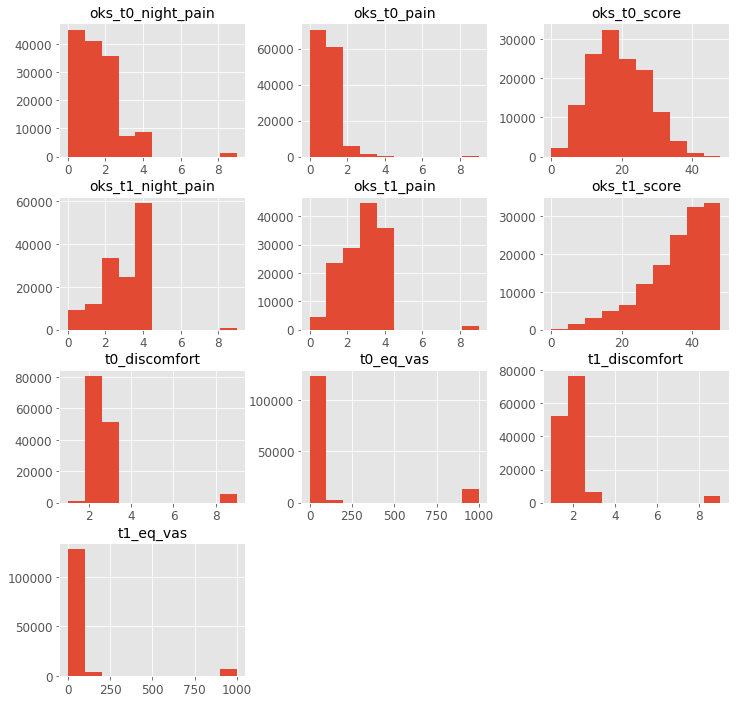

In [5]:
# inspect with histograms
df.loc[:,proms].hist(figsize=M);

In [6]:
# EQ-VAS score has outlier values at 999
df.t0_eq_vas.value_counts()

80     17497
70     14573
999    12961
50     12621
90     12297
       ...  
7         16
4         16
11        15
13        14
6         11
Name: t0_eq_vas, Length: 102, dtype: int64

In [7]:
# 999 is a so-called sentinel value for missing values
df.loc[:,['t0_eq_vas', 't1_eq_vas']].replace(999, np.nan).astype('Int64').dtypes

t0_eq_vas    Int64
t1_eq_vas    Int64
dtype: object

In [8]:
# But why isn't it updated?
df.loc[:,['t0_eq_vas', 't1_eq_vas']]

,t0_eq_vas,t1_eq_vas
0,80,999
1,999,95
2,999,98
3,999,60
4,75,80
...,...,...
47599,85,83
47600,15,90
47601,85,85
47602,85,50


In [9]:
# when using iloc or loc you need to specify a location to update with some value.
# explicitly make new copy
dfc = df.copy()
dfc.loc[:,['t0_eq_vas', 't1_eq_vas']] = dfc.loc[:,['t0_eq_vas', 't1_eq_vas']].replace(999, np.nan).astype('Int64')
dfc.loc[:,['t0_eq_vas', 't1_eq_vas']]

,t0_eq_vas,t1_eq_vas
0,80,NaN
1,NaN,95
2,NaN,98
3,NaN,60
4,75,80
...,...,...
47599,85,83
47600,15,90
47601,85,85
47602,85,50


In [10]:
# simarly, change 9 to N/A for OKS
_no9 = [col for col in df.columns if col.startswith('oks_t') and not col.endswith('score')]
dfc.loc[:,_no9] = df.loc[:,_no9].replace(9, np.nan).astype('Int64')

# check number of NAs
pd.concat([df.loc[:,_no9].isnull().sum(), dfc.loc[:,_no9].isnull().sum()], axis=1, keys=['df', 'dfc'])

,df,dfc
oks_t0_pain,0,198
oks_t0_night_pain,0,1304
oks_t0_washing,0,125
oks_t0_transport,0,1350
oks_t0_walking,0,1443
oks_t0_standing,0,1453
oks_t0_limping,0,1415
oks_t0_kneeling,0,1396
oks_t0_work,0,1356
oks_t0_confidence,0,1342


In [11]:
# we are just going to drop all NAs
dfc = dfc.dropna()
print(f'Raw data:   {df.shape[0]} rows\nNo NA data: {dfc.shape[0]} rows\n # dropped:  {df.shape[0] - dfc.shape[0]} rows')

Raw data:   139236 rows
No NA data: 103486 rows
 # dropped:  35750 rows


In [12]:
# let inspect data again
dfc.loc[:,proms].describe()

,oks_t0_score,oks_t1_score,oks_t0_pain,oks_t1_pain,oks_t0_night_pain,oks_t1_night_pain,t0_discomfort,t1_discomfort,t0_eq_vas,t1_eq_vas
count,103486.000000,103486.000000,103486.000000,103486.000000,103486.000000,103486.000000,103486.000000,103486.000000,103486.000000,103486.000000
mean,19.222794,36.186054,0.573179,2.629747,1.239520,2.834789,2.363827,1.650600,67.643024,75.197698
std,7.717541,9.301257,0.642801,1.131023,1.147203,1.243517,0.502307,0.560599,20.468276,17.965972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,14.000000,31.000000,0.000000,2.000000,0.000000,2.000000,2.000000,1.000000,51.000000,68.000000
50%,19.000000,38.000000,1.000000,3.000000,1.000000,3.000000,2.000000,2.000000,70.000000,80.000000
75%,25.000000,44.000000,1.000000,4.000000,2.000000,4.000000,3.000000,2.000000,80.000000,90.000000
max,48.000000,48.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,100.000000,100.000000


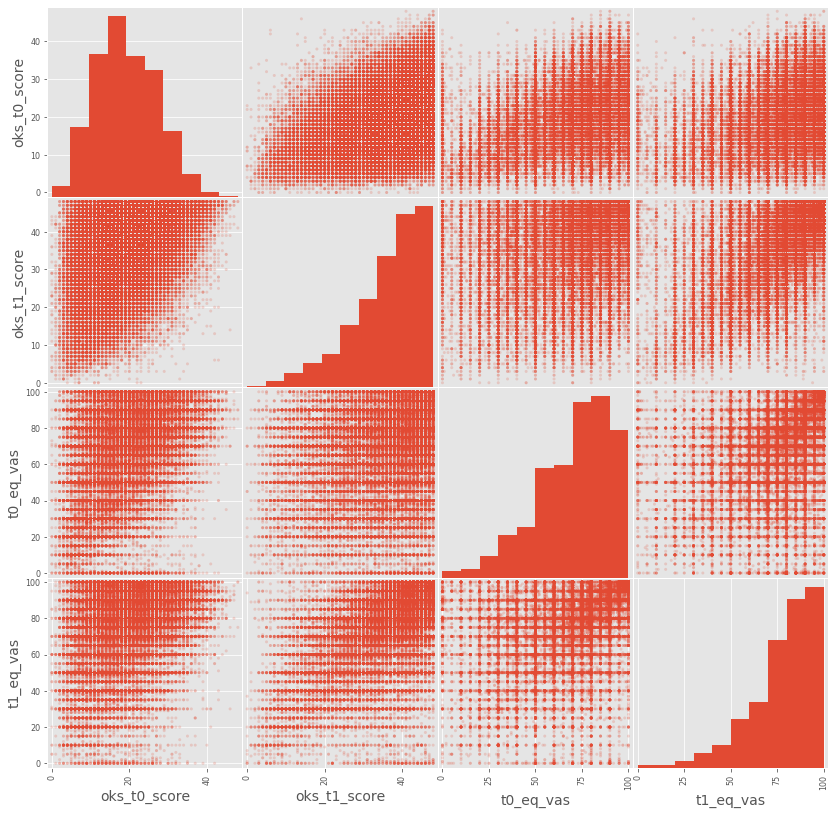

In [18]:
# 3-point scales don't look that interesting, let's zoom in on oks_score and eq_vas
# note some functions don't work with nullable integer Int64 (yet), so converting back to int64
oks_vas = ['oks_t0_score', 'oks_t1_score', 't0_eq_vas', 't1_eq_vas']
pd.plotting.scatter_matrix(dfc.loc[:,oks_vas].astype('int64'), figsize=L, alpha=0.2);

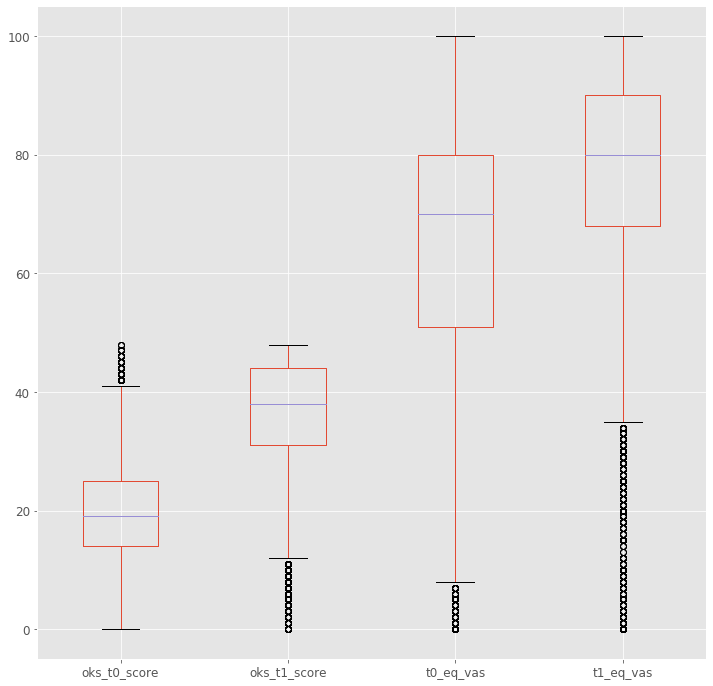

In [21]:
dfc.loc[:, oks_vas].boxplot(figsize=M);

In [0]:
# NB: kde can't handle Int64, hence casting back to float64
eq_vas.plot(kind='hist', bins=10, density=True, figsize=FIGSIZE, alpha=0.5);

In [0]:
---
title: "Data Exploration"
---
###### Joran Lokkerbol; sept 2019

```{r}
knitr::opts_chunk$set(echo = TRUE)
options(scipen=999)
```

```{r}
#install.packages("rmarkdown")
#install.packages("psych")
#install.packages("ggplot2")
#install.packages("summarytools")
#install.packages("corrplot")
#install.packages("purrr")
#install.packages("tidyr")
#install.packages("caret")
#install.packages("rpart")
#install.packages("rpart.plot")
#install.packages("rattle")
#install.packages("dplyr")
#install.packages("DescTools")
library(rmarkdown)
library(psych)
library(ggplot2)
library(corrplot)
library(purrr)
library(tidyr)
library(caret)
library(rpart)
library(rpart.plot)
library(rattle)
library(dplyr)
library(DescTools)
rm(list = ls())  # Delete everything that is in R's memory
setwd("/Users/joranlokkerbol/Documents/ML-institute/content - opleiding/dag1/")
dataset <- read.csv("student-por.csv", header = TRUE)
dataset <- as.data.frame(dataset)
class(dataset)
```




## Describing the data (general)

```{r}
#View(dataset)
str(dataset)
describeFast(dataset)
dataset %>%
  keep(is.numeric) %>% describe
#suppressWarnings(print(dfSummary(dataset), method = 'render', silent=TRUE))
# map the number of missings
sapply(dataset, function(x) sum(is.na(x))) 
# map levels and frequencies per categorical variable
temp <-  dataset %>% keep(is.factor)
for (i in 1:ncol(temp)) {
        print(names(temp[i]))
        print(Freq(temp[,i]))}
```

## Histrograms per variable to check distribution and outliers
```{r}
dataset %>%
  keep(is.numeric) %>%
  gather() %>%
  ggplot(aes(value)) +
  facet_wrap(~ key, scales = "free") +
  geom_histogram()
```


## Identify near-zero variances predictors
```{r}
nearZeroVar(dataset, saveMetrics = TRUE)
```


## Exploring the outcome Y

```{r}
##### SET Y #######
dataset$Y <- dataset$health ## set Y
dataset <- subset(dataset, select=-c(health)) ### delete "health" to prevent duplicates
##### describe Y #####
plot(dataset$Y)
table(dataset$Y)
summary(dataset$Y)
boxplot(dataset$Y)
histogram(dataset$Y)
plot.ecdf(dataset$Y)
sum(is.na(dataset$Y)) #nr of missings affect generalizability of your model
# define Y as a binary variable
dataset$Y[dataset$Y < 3.5] <- 0
dataset$Y[dataset$Y >= 3.5] <- 1
table(dataset$Y)
```


## Correlation matrix
```{r}
res <- cor(dataset[unlist(lapply(dataset, is.numeric))])
corrplot(res, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)
```

## Scatterplots to check for (non-)linear relations
```{r}
temp <- dataset %>% keep(is.numeric)
a <- ncol(temp)
b <- a/2
pairs(Y~.,data=temp[,c(1:b,a)], main="Scatterplot Matrix")
pairs(Y~.,data=temp[,c((b+1):a)], main="Scatterplot Matrix")
```



## Boxplots of categorical variables and Y 
```{r}
bp <- dataset[unlist(lapply(dataset, is.factor))]
bp$Y <- as.numeric(dataset$Y)
 for(k in 1:ncol(bp)){
 print(names(bp[k]))
   boxplot(bp$Y ~ bp[, k])
  #ggplot(bp, aes(x=bp[,k], y=bp$Y)) + 
#  geom_boxplot()
}
```

## Chi-square tests of categorical variables with Y
```{r}
cs <- dataset[unlist(lapply(dataset, is.factor))]
cs$Y <- dataset$Y
 for(k in 1:(ncol(cs)-1)){
 print(names(cs[k]))
 print(chisq.test(cs$Y, cs[, k]), correct = FALSE)
  #ggplot(bp, aes(x=bp[,k], y=bp$Y)) + 
#  geom_boxplot()
}
```

## Simple regression tree with all predictors and Y
```{r}
tree <- rpart(Y~., data = dataset)
rpart.plot(tree)
```

## Simple regression tree for all predictors separately and Y
```{r}
## Rpart or every single x and y 
for(i in 1:ncol(dataset)){
print(names(dataset)[i])
tree <- rpart(Y~dataset[,i], data = dataset)
rpart.plot(tree)   }
```
## Regression tree for a set of correlated predictors on Y
```{r}
temp <- select(dataset, Y, G1, G2, G3)
tree <- rpart(Y~., data = temp)
rpart.plot(tree)
```

## Other things to look into
* do infeasible combinations of variable values occur in the data (e.g. minors with a drivers license or pregnant males)? 
* a tree-model where Y is being predicted using a cluster of related X-variables, such as ROM-items
* which variables are known / not known at the point of prediction?
* which domains (work, health, family, lifestyle, therapy, etc etc) are covered?


## Results
* assessment of the quality of the data (in terms of outliers and missings)
* input regarding the moment of prediction
* input for data cleaning (handling missing data; removing variables not known at time of prediction, near-zero variance variables, etc)
* input for feature engineering (adjusting variables based on tree-analyses, based on correlations, based on domain-analysis)
* input for defining the outcome variable Y
* input for defining the project in terms of generalizability (in case of missing Y values)
* input for choosing the project in case there are still multiple options at the table
* input for defining the scope of the project (e.g. limiting to a subgroup to get a better balanced outcome variable)
* a potential revision of the goal of your project
* input for which variables and combination of variables seem particularly relevant within the to-be-developed algorithms 
© 2020 GitHub, Inc.
Terms
Privacy
Security
Status
Help
Contact GitHub
Pricing
API
Training
Blog
About
